In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat import load_generator_network, get_shallow_copy_function
from definitions.predictor.aparent_w_dense_functional import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

class GenesisMonitor(Callback):
    def __init__(self, generator_model, sequence_encoder, run_dir="", run_prefix="", n_sequences=32, batch_size=32, input_tensor_funcs=None) :
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.n_sequences = n_sequences
        self.input_tensor_funcs = input_tensor_funcs
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        n_batches = self.n_sequences // self.batch_size
        
        self.input_tensors = [self.input_tensor_funcs[i](i) for i in range(len(self.input_tensor_funcs))]
        gen_bundle = self.generator_model.predict(x=self.input_tensors, batch_size=self.batch_size)
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0]) for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.n_sequences) + "_sequences.txt", "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)


In [3]:

def get_latent_margin_sample_cosine(margin=0.5) : 

    def latent_margin_sample_cosine(seed1, seed2) :
        
        rescaled_seed1 = seed1#(seed1 + 1.) / 2.
        rescaled_seed2 = seed2#(seed2 + 1.) / 2.
        
        mean_sample_ent = K.sum(rescaled_seed1 * rescaled_seed2, axis=-1) / (K.sqrt(K.sum(rescaled_seed1**2, axis=-1)) * K.sqrt(K.sum(rescaled_seed2**2, axis=-1)))
        
        margin_sample_ent = K.switch(mean_sample_ent > K.constant(margin, shape=(1,)), mean_sample_ent - margin, K.zeros_like(mean_sample_ent))
        
        return margin_sample_ent

    return latent_margin_sample_cosine

#Define target isoform loss function
def get_isoform_loss(target_isos, fitness_weight=2.0, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, entropy_loss_mode='margin', sequence_similarity_weight=0.0, sequence_similarity_margin=0.0, dense_1_similarity_weight=0.0, dense_1_similarity_margin=0.0, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    if entropy_loss_mode == 'margin' :
        masked_use_entropy_mse = get_margin_entropy_ame_masked(pwm_start=use_start, pwm_end=use_end, min_bits=use_target_bits)
        cse_entropy_mse = get_margin_entropy_ame(pwm_start=cse_start, pwm_end=cse_end, min_bits=cse_target_bits)
        masked_dse_entropy_mse = get_margin_entropy_ame_masked(pwm_start=dse_start, pwm_end=dse_end, min_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=sequence_similarity_margin, shift_1_nt=True)
    
    dense_1_sample_entropy_func = get_latent_margin_sample_cosine(margin=dense_1_similarity_margin)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred_1, _, _, _, dense_1_pred_1, iso_pred_2, _, _, _, dense_1_pred_2 = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = fitness_weight * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred_1), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        entropy_loss = entropy_weight * ((masked_use_entropy_mse(pwm_1, mask) if use_target_bits is not None else 0.0) + (cse_entropy_mse(pwm_1) if cse_target_bits is not None else 0.0) + (masked_dse_entropy_mse(pwm_1, mask) if dse_target_bits is not None else 0.0))
        
        sequence_similarity_loss = sequence_similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        dense_1_similarity_loss = dense_1_similarity_weight * K.mean(dense_1_sample_entropy_func(dense_1_pred_1, dense_1_pred_2), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss + sequence_similarity_loss + dense_1_similarity_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(run_prefix, sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, n_intermediate_sequences=960) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Validation Generator Network
    _, val_generator = get_generator_copier(generator)(batch_size, len(sequence_templates[0]), get_shallow_copy_function(generator), n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False, validation_sample_mode='sample', supply_inputs=True)
    
    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor_w_adversary(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
    
    #Randomized validation tensors
    val_random_tensor_funcs = [
        lambda i: np.array(np.zeros(n_intermediate_sequences)).reshape(-1, 1),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100)),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100))
    ]

    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    random_genesis_monitor = GenesisMonitor(val_generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", n_sequences=n_intermediate_sequences, batch_size=batch_size, input_tensor_funcs=val_random_tensor_funcs)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[random_genesis_monitor]
    )
    
    train_history = None

    return generator, predictor, train_history


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [5]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

model_prefix = "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_seq_05_lat_07_latent_penalty"

#Number of PWMs to generate per objective
batch_size = 64
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 250
#Number of steps (grad updates) per epoch
steps_per_epoch = 100

#Number of sequences to sample and store for each epoch
n_intermediate_sequences = 960

K.clear_session()

loss = get_isoform_loss(
    [1.0],
    fitness_weight=2.0,
    use_start=25,
    use_end=70,
    use_target_bits=1.8,
    cse_start=70,
    cse_end=76,
    cse_target_bits=None,#1.8,
    dse_start=76,
    dse_end=121,
    dse_target_bits=1.8,
    entropy_weight=1.0,
    sequence_similarity_weight=5.0,
    sequence_similarity_margin=0.5,
    dense_1_similarity_weight=5.0,
    dense_1_similarity_margin=0.7,
    punish_dn_cse=0.0,
    punish_up_c=0.0,
    punish_dn_c=0.0,
    punish_up_g=0.0,
    punish_dn_g=0.0,
    punish_up_aa=0.0,
    punish_dn_aa=0.0,
)

generator_model, predictor_model, train_history = run_genesis(model_prefix, [sequence_templates[0]], loss, [library_contexts[0]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch, n_intermediate_sequences)

generator_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

predictor_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = model_prefix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model.save(model_path)
print('Saved trained model at %s ' % model_path)


In [59]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

saved_predictor = load_model(saved_predictor_model_path)

acgt_encoder = IdentityEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


iso_pred = 0.99833435
score_pred = 6.3958717211963645


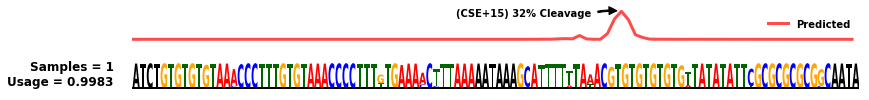

iso_pred = 0.99076885
score_pred = 4.675897606976785


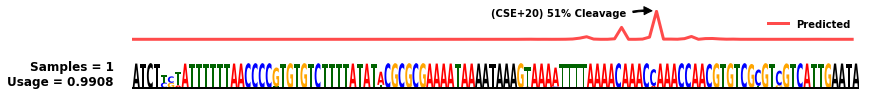

iso_pred = 0.99523735
score_pred = 5.342177113268509


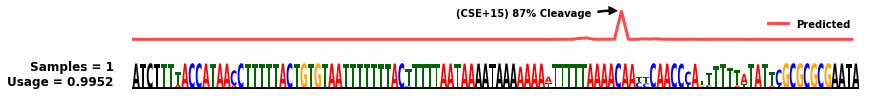

iso_pred = 0.99799025
score_pred = 6.2077334633941135


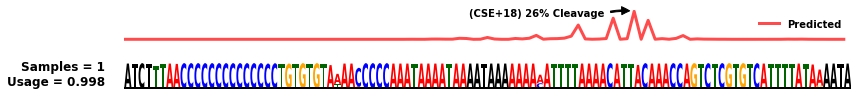

iso_pred = 0.9911584
score_pred = 4.719409449322933


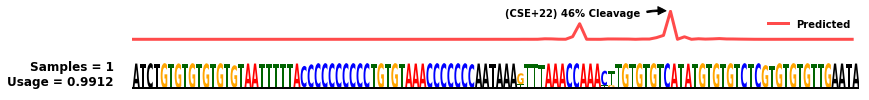

iso_pred = 0.99653023
score_pred = 5.660192558182063


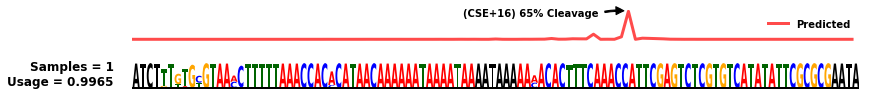

iso_pred = 0.9996314
score_pred = 7.905443080100259


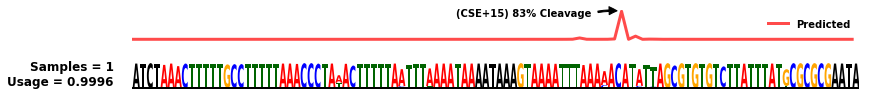

iso_pred = 0.9983077
score_pred = 6.379975910489029


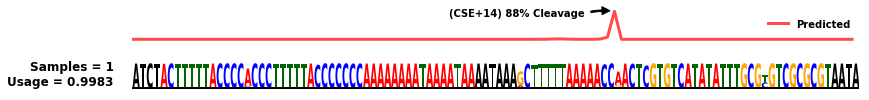

iso_pred = 0.996141
score_pred = 5.553485019224239


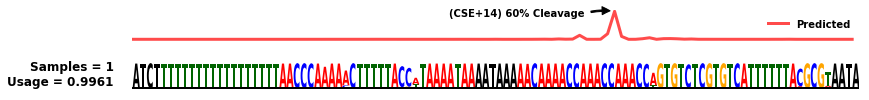

iso_pred = 0.99861556
score_pred = 6.581076263060432


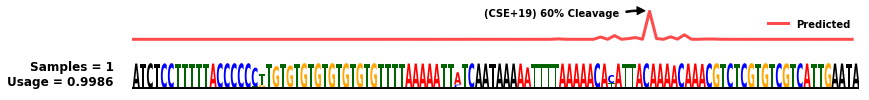

iso_pred = 0.9996588
score_pred = 7.982767957561542


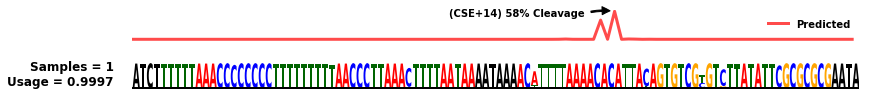

iso_pred = 0.9991615
score_pred = 7.083035469949128


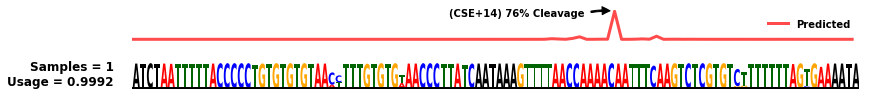

iso_pred = 0.9956509
score_pred = 5.433424877818547


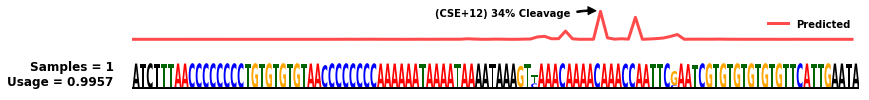

iso_pred = 0.9922571
score_pred = 4.853208324813986


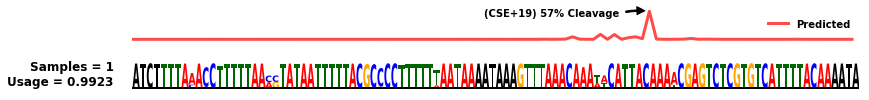

iso_pred = 0.9949564
score_pred = 5.284573656676737


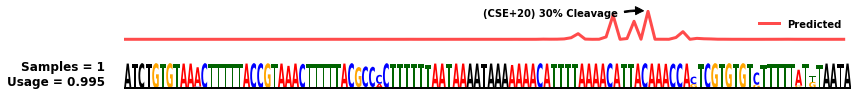

iso_pred = 0.99863505
score_pred = 6.595274265143174


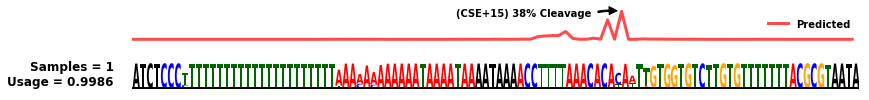

In [61]:
#Load GENESIS models and predict sample sequences

model_prefix = "genesis_apa_max_isoform_simple_25000_updates_similarity_margin_seq_05_lat_07_latent_penalty"
batch_size = 64

sequence_template = sequence_templates[0]

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

n = batch_size

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

#Make predictions using black box model

fake_lib = np.zeros((optimized_pwm.shape[0], 13))
fake_lib[:, 5] = 1.
fake_d = np.ones((optimized_pwm.shape[0], 1))

iso_pred, cut_pred = saved_predictor.predict(x=[sampled_pwm[:, 0, ...], fake_lib, fake_d], batch_size=batch_size)

for pwm_index in range(16) :

    print("iso_pred = " + str(iso_pred[pwm_index, 0]))
    print("score_pred = " + str(np.log(iso_pred[pwm_index, 0] / (1. - iso_pred[pwm_index, 0]))))

    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cut_pred[pwm_index, :], axis=0)
    iso = np.expand_dims(iso_pred[pwm_index], axis=0)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_templates[0], figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-49, plot_end=76+49, save_figs=False, fig_name=model_prefix + "_pwm_index_" + str(pwm_index), fig_dpi=150)


In [62]:
#Load GENESIS models and predict sample sequences

n = 1000
n_slack = 0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model
fake_lib = np.zeros((optimized_pwm.shape[0], 13))
fake_lib[:, 5] = 1.
fake_d = np.ones((optimized_pwm.shape[0], 1))

iso_pred, _ = saved_predictor.predict(x=[sampled_pwm[:, 0, ...], fake_lib, fake_d], batch_size=batch_size)

prob_pred = np.ravel(iso_pred)
score_pred = np.log(prob_pred / (1. - prob_pred))

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]
prob_pred = prob_pred[sort_index][:n]


mean proportion = 0.9972
std proportion = 0.0018
mean score = 6.1762
std score = 0.8459
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


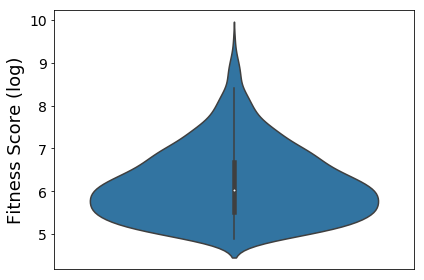

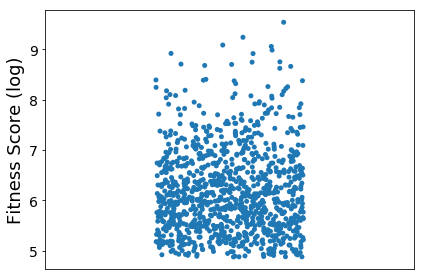

In [63]:
import seaborn as sns

#Target vs. Engineered Isoform Log Odds

save_figs = False

print("mean proportion = " + str(round(np.mean(prob_pred), 4)))
print("std proportion = " + str(round(np.std(prob_pred), 4)))
print("mean score = " + str(round(np.mean(score_pred), 4)))
print("std score = " + str(round(np.std(score_pred), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[score_pred])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_violin.eps")
    plt.savefig(model_prefix + "_fitness_score_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[score_pred], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_stripplot.eps")
    plt.savefig(model_prefix + "_fitness_score_stripplot.svg")

plt.show()


In [64]:
#Calculate average/std nucleotide entropy

nt_entropies = []
for j in range(onehots.shape[1]) :
    if sequence_templates[0][j] == 'N' :

        p_A = np.sum(onehots[:, j, 0]) / n
        p_C = np.sum(onehots[:, j, 1]) / n
        p_G = np.sum(onehots[:, j, 2]) / n
        p_T = np.sum(onehots[:, j, 3]) / n

        nt_entropy = 0
        if p_A * p_C * p_G * p_T > 0. :
            nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))

        nt_entropies.append(nt_entropy)

nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


#Calculate hexamer entropies

hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
])

hexamer_sum = np.ravel(hexamers.sum(axis=0))
hexamers_probs = hexamer_sum / np.sum(hexamer_sum)
n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

print("Number of unique hexamers = " + str(n_nonzero_hexamers))

hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

print("Hexamer Entropy = " + str(hexamer_entropy))


#Calculate average/std hexamer entropy

nonzero_index = np.nonzero(hexamer_sum > 0)[0]

hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on

    hexamer_entropy = 0
    if p_on * p_off > 0. :
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))



Mean NT Entropy = 1.4092
Std NT Entropy = 0.6661
Number of unique hexamers = 1996
Hexamer Entropy = 8.490018554847767
Mean Binary Hexamer Entropy = 0.1469
Std Binary Hexamer Entropy = 0.2231


mean distance/nt = 0.4747
std distance/nt = 0.0736
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


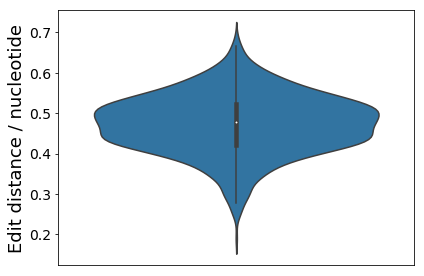

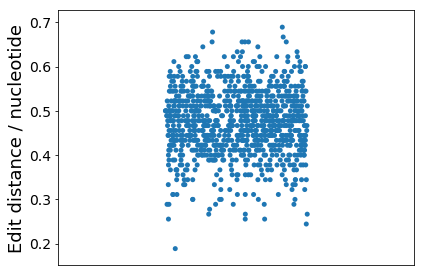

In [65]:
import editdistance

#Calculate random pair-wise edit distances

save_figs = False

seqs = [
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
]

shuffle_index = np.arange(len(seqs))
np.random.shuffle(shuffle_index)

distances = []
for i in range(len(seqs)) :
    if i == shuffle_index[i] :
        continue
    
    seq_1 = seqs[i]
    seq_2 = seqs[shuffle_index[i]]
    
    dist = editdistance.eval(seq_1, seq_2)

    distances.append(dist)

    import seaborn as sns

distances = np.array(distances) / np.sum([1 if sequence_templates[0][j] == 'N' else 0 for j in range(len(sequence_templates[0]))])

print("mean distance/nt = " + str(round(np.mean(distances), 4)))
print("std distance/nt = " + str(round(np.std(distances), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[distances])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_violin.eps")
    plt.savefig(model_prefix + "_edit_distance_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[distances], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_stripplot.eps")
    plt.savefig(model_prefix + "_edit_distance_stripplot.svg")

plt.show()


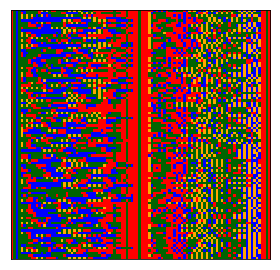

In [66]:

plot_n_seqs = 100
plot_start = 70-49
plot_end = 76+49

save_figs = False

flat_pwms = np.zeros((pwms.shape[0], pwms.shape[1]))
for i in range(pwms.shape[0]) :
    for j in range(pwms.shape[1]) :
        max_nt_ix = np.argmax(pwms[i, j, :])

        flat_pwms[i, j] = max_nt_ix + 1

flat_pwms = flat_pwms[:plot_n_seqs, plot_start:plot_end]

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_diversity_seqs.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_diversity_seqs.svg")
    plt.savefig(model_prefix + "_diversity_seqs.eps")

plt.show()


In [67]:
#Get latent space predictor
saved_predictor_w_dense = Model(
    inputs = saved_predictor.inputs,
    outputs = saved_predictor.outputs + [saved_predictor.get_layer('dropout_1').output]
)
saved_predictor_w_dense.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))


In [68]:
#Load GENESIS models and predict sample sequences

batch_size = 64

n = 4096#10000
n_slack = 0#0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size
if n_ceil < n :
    n_ceil += batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model
fake_lib = np.zeros((optimized_pwm.shape[0], 13))
fake_lib[:, 5] = 1.
fake_d = np.ones((optimized_pwm.shape[0], 1))

iso_pred, _, dense_pred = saved_predictor_w_dense.predict(x=[sampled_pwm[:, 0, ...], fake_lib, fake_d], batch_size=batch_size)

prob_pred = np.ravel(iso_pred)
score_pred = np.log(prob_pred / (1. - prob_pred))

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]
prob_pred = prob_pred[sort_index][:n]
dense_pred = dense_pred[sort_index][:n]


In [70]:
#Save sequences to file
with open(model_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(onehots.shape[0]) :
        seq = acgt_encoder.decode(onehots[i])
        
        f.write(seq + "\n")
